In [1]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND #Hint: this is useful when defining the modified attention mechanism

With the default config, you can get 10-15% dev WER within 20 epochs. Each epoch will take 5 secs on a GPU and 10 secs on CPU

In [3]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=None):
        """
        Initialize Attention.
        ----
        enc_dim: encoder hidden state dimension
        dec_dim: decoder hidden state dimension
        attn_dim: attention feature dimension
        """
        super(Attention, self).__init__()
        if enc_dim == dec_dim and attn_dim is None:
            self.use_default = True
        elif attn_dim is not None:
            self.use_default = False
            self.attn_dim = attn_dim
            self.enc_dim = enc_dim
            self.dec_dim = dec_dim
            self.v = LinearND(self.attn_dim, 1, bias=False)
            self.W1 = LinearND(self.enc_dim, self.attn_dim, bias=False)
            self.W2 = nn.Linear(self.dec_dim, self.attn_dim, bias=False)
        else:
            raise ValueError("invalid args (enc_dim={}, dec_dim={}, attn_dim={})".format(enc_dim, dec_dim, attn_dim))

    def forward(self, eh, dhx, ax=None):
        """
        Forward Attention method.
        ----
        eh (FloatTensor): the encoder hidden state with
            shape (batch size, time, hidden dimension).
        dhx (FloatTensor): one time step of the decoder hidden
            state with shape (batch size, 1, hidden dimension).
        ax (FloatTensor): one time step of the attention vector.
        ----
        Returns the context vectors (sx) and the corresponding attention alignment (ax)
        """
        
        if self.use_default:
            # Compute inner product of decoder slice with every encoder slice
            pax = torch.sum(eh * dhx, dim=2)
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax.unsqueeze(2), dim=1, keepdim=True)
        else:
            # TODO: Modify the attention mechanism
            pax = self.v.forward(torch.tanh(self.W1.forward(eh) + self.W2.forward(dhx)))
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax, dim=1, keepdim=True)
            ax = ax.squeeze(-1)
        return sx, ax

In [4]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.mean(losses)

def evaluate(model, ldr, preproc):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    return np.mean(losses), compute_wer(results)

In [5]:
# global config, if not overridden
with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

In [6]:
# data
preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

In [7]:
# TODO: tune on the dev set
# may want to set up function or chunk of code here to perform tuning
# call train on training set, call evaluate on dev, save/plot/compare results

# global training util
global_best_wer = float("inf")
global_best_fn = 'best.pkl'
log = "epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

In [8]:
def plot_wer_loss(title, plotting, xlabel='# epochs', xticks=None):
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    if xticks is None:
        plt.plot(plotting['WER'], label='WER')
    else:
        plt.plot(xticks, plotting['WER'], label='WER')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('WER')
    plt.subplot(1, 2, 2)
    if xticks is None:
        plt.plot(plotting['dev_loss'], label='dev_loss')
        plt.plot(plotting['train_loss'], label='train_loss')
    else:
        plt.plot(xticks, plotting['dev_loss'], label='dev_loss')
        plt.plot(xticks, plotting['train_loss'], label='train_loss')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('loss')
    plt.savefig('figures/' + title + '.png')
    plt.show()

In [9]:
def tune(hyperparams):
    """hyperparams is a dict object"""
    # override global with hyperparams passed into this function
    attn_dim = hyperparams.get('attn_dim', None)
    lr = hyperparams.get('lr', opt_cfg["learning_rate"])
    enc_hid = hyperparams.get('enc_hid', model_cfg["encoder"]["hidden_size"])
    dec_hid = hyperparams.get('dec_hid', model_cfg["decoder"]["hidden_size"])
    sample_prob = hyperparams.get('sample_prob', config['model']['sample_prob'])
    
    curr_config = 'at{}+lr{}+enc{}+dec{}+sp{}'.format(attn_dim, lr, enc_hid, dec_hid, 
                                                          sample_prob)
    print('\nTrain RNN with config:', curr_config)
    
    # model initialization
    attention = Attention(enc_hid, dec_hid, attn_dim=attn_dim)
    
    model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
    model = model.cuda() if use_cuda else model.cpu()
    model.sample_prob = sample_prob
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=opt_cfg["momentum"])
    
    curr_best_wer = float('inf') # parallel to global_best_wer
    plotting = {'WER': [], 'train_loss': [], 'dev_loss': []}
    
    for ep in range(opt_cfg["max_epochs"]):
        start = time.time()
        train_loss = train(model, optimizer, train_ldr)    
        dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
        print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
        
        plotting['WER'].append(dev_wer)
        plotting['train_loss'].append(train_loss)
        plotting['dev_loss'].append(dev_loss)
        
#         torch.save(model, os.path.join(config["save_path"], curr_config + '_' + str(ep)))
        # is this curr model best?
        if dev_wer < curr_best_wer:
            curr_best_wer = dev_wer
            torch.save(model, os.path.join(config["save_path"], curr_config))
        # is this global best?
        global global_best_wer
        if dev_wer < global_best_wer:
            global_best_wer = dev_wer
            torch.save(model, os.path.join(config["save_path"], global_best_fn))
        
    return curr_config, plotting

### (e) i. Plot the loss and word error rate (WER) vs. epoch on train and dev for the default attention model


Train RNN with config: atNone+lr1+enc16+dec16+sp0.9


/home/ruolinzheng/.local/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.71, dev_loss=  4.88 with  79.82% WER (  3.16s elapsed)


/home/ruolinzheng/.local/lib/python3.5/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch    2 | train_loss=  4.11, dev_loss=  3.73 with  71.43% WER (  3.06s elapsed)
epoch    3 | train_loss=  3.56, dev_loss=  3.36 with  60.71% WER (  3.06s elapsed)
epoch    4 | train_loss=  3.14, dev_loss=  2.85 with  53.04% WER (  3.05s elapsed)
epoch    5 | train_loss=  2.62, dev_loss=  2.19 with  37.14% WER (  3.06s elapsed)
epoch    6 | train_loss=  1.49, dev_loss=  1.54 with  24.64% WER (  3.05s elapsed)
epoch    7 | train_loss=  1.01, dev_loss=  1.53 with  24.82% WER (  3.05s elapsed)
epoch    8 | train_loss=  1.07, dev_loss=  1.37 with  20.18% WER (  3.05s elapsed)
epoch    9 | train_loss=  0.91, dev_loss=  1.17 with  16.79% WER (  3.05s elapsed)
epoch   10 | train_loss=  0.96, dev_loss=  1.13 with  19.11% WER (  3.06s elapsed)
epoch   11 | train_loss=  0.87, dev_loss=  0.78 with  13.75% WER (  3.05s elapsed)
epoch   12 | train_loss=  0.58, dev_loss=  0.74 with  11.79% WER (  3.07s elapsed)
epoch   13 | train_loss=  0.44, dev_loss=  0.63 with  10.54% WER (  3.05s elapsed)
epoc

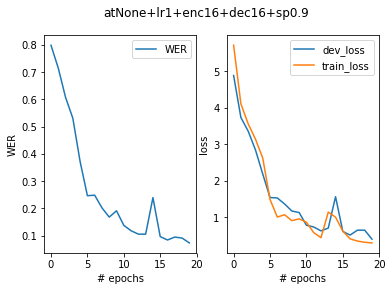

In [10]:
# default
plt_title, plotting = tune({})
plot_wer_loss(plt_title, plotting)

### (e) ii. For models trained with scheduled sampling rates 0.3, 0.6, 0.9, plot loss and WER vs. sampling probability.

In [11]:
def experiment(param_name, param_range):
    data = {'WER': [], 'dev_loss': [], 'train_loss': []}
    for param in param_range:
        hp = {param_name: param}
        _, plotting = tune(hp)
        # record best WER/loss
        idx = np.argmin(plotting['WER'])
        for k in data:
            data[k].append(plotting[k][idx])
    #     plot_wer_loss(best, plotting)
    plot_wer_loss(param_name, data, xlabel=param_name, xticks=param_range)


Train RNN with config: atNone+lr1+enc16+dec16+sp0.3
epoch    1 | train_loss=  5.20, dev_loss=  4.56 with  81.96% WER (  3.06s elapsed)
epoch    2 | train_loss=  4.00, dev_loss=  4.09 with  75.00% WER (  3.06s elapsed)
epoch    3 | train_loss=  3.40, dev_loss=  3.21 with  63.57% WER (  3.07s elapsed)
epoch    4 | train_loss=  2.96, dev_loss=  2.84 with  61.96% WER (  3.06s elapsed)
epoch    5 | train_loss=  2.36, dev_loss=  1.95 with  38.39% WER (  3.07s elapsed)
epoch    6 | train_loss=  2.11, dev_loss=  2.35 with  44.64% WER (  3.07s elapsed)
epoch    7 | train_loss=  1.92, dev_loss=  2.35 with  45.89% WER (  3.11s elapsed)
epoch    8 | train_loss=  1.60, dev_loss=  2.19 with  40.00% WER (  3.20s elapsed)
epoch    9 | train_loss=  1.79, dev_loss=  1.42 with  24.46% WER (  3.20s elapsed)
epoch   10 | train_loss=  1.35, dev_loss=  1.31 with  20.89% WER (  3.21s elapsed)
epoch   11 | train_loss=  1.31, dev_loss=  1.66 with  27.86% WER (  3.21s elapsed)
epoch   12 | train_loss=  1.32, de

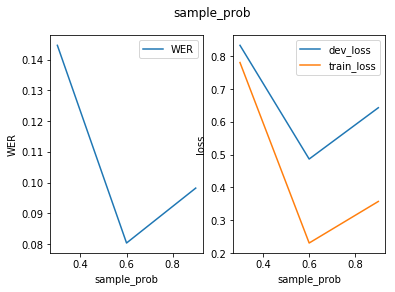

In [12]:
experiment('sample_prob', [0.3, 0.6, 0.9])

## (e) iii. For models trained with learning rate 0.1, 0.5, 1, plot loss and WER vs. sampling probability.


Train RNN with config: atNone+lr0.1+enc16+dec16+sp0.9
epoch    1 | train_loss=  6.05, dev_loss=  5.96 with  91.61% WER (  3.05s elapsed)
epoch    2 | train_loss=  5.10, dev_loss=  5.56 with  86.96% WER (  3.05s elapsed)
epoch    3 | train_loss=  4.87, dev_loss=  5.25 with  77.50% WER (  3.06s elapsed)
epoch    4 | train_loss=  4.69, dev_loss=  4.82 with  74.64% WER (  3.06s elapsed)
epoch    5 | train_loss=  4.47, dev_loss=  4.52 with  79.64% WER (  3.11s elapsed)
epoch    6 | train_loss=  4.29, dev_loss=  4.33 with  71.79% WER (  3.20s elapsed)
epoch    7 | train_loss=  4.10, dev_loss=  4.19 with  65.89% WER (  3.20s elapsed)
epoch    8 | train_loss=  3.94, dev_loss=  4.04 with  70.36% WER (  3.20s elapsed)
epoch    9 | train_loss=  3.82, dev_loss=  3.94 with  65.71% WER (  3.21s elapsed)
epoch   10 | train_loss=  3.68, dev_loss=  3.86 with  68.93% WER (  3.20s elapsed)
epoch   11 | train_loss=  3.66, dev_loss=  3.70 with  60.89% WER (  3.20s elapsed)
epoch   12 | train_loss=  3.52, 

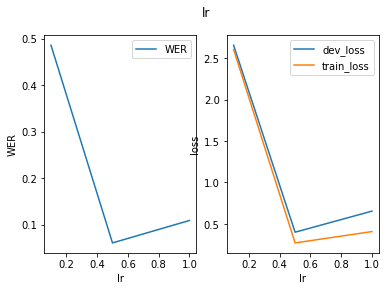

In [13]:
experiment('lr', [0.1, 0.5, 1])

## Test on global best

In [14]:
print("Testing RNN")
test_model = torch.load(os.path.join(config["save_path"], global_best_fn))
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])

_, test_wer = evaluate(test_model, test_ldr, preproc)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
4.52% WER (test)
